# Masked Language Modeling (MLM)

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# print(tf.__version__)

### Installation of dependencies

In [3]:
# Install necessary packages
# !pip install nltk
# !pip install transformers
# !pip install matplotlib

### Import necessary packages

In [4]:
import os
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import BertForMaskedLM, BertTokenizer
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Implementation

In [6]:
# Function to read and tokenize text files from a directory
def read_and_tokenize(directory):
    sentences = []
    for file in os.listdir(directory):
        with open(os.path.join(directory, file), 'r', encoding='utf-8') as f:
            print(file)
            text = f.read()
            sentences.extend(sent_tokenize(text))
    return sentences

# Directory path to your dataset
directory_path = 'E:\\FYP\\Jupyter\\NewSelectedFiles'
text_data = read_and_tokenize(directory_path) #contains sentences tokenized from all files in my data directory

file10009.txt
file10073.txt
file10220.txt
file10318.txt
file1036.txt
file10373.txt
file10410.txt
file10425.txt
file10440.txt
file10495.txt
file10496.txt
file10571.txt
file10578.txt
file10653.txt
file10669.txt
file10760.txt
file10778.txt
file10791.txt
file10850.txt
file11178.txt
file11218.txt
file11537.txt
file11626.txt
file11630.txt
file11800.txt
file11884.txt
file12069.txt
file1217.txt
file12225.txt
file12386.txt
file1249.txt
file12582.txt
file12662.txt
file12810.txt
file12851.txt
file12998.txt
file13011.txt
file13102.txt
file13169.txt
file13217.txt
file13245.txt
file13267.txt
file13605.txt
file13709.txt
file13718.txt
file138.txt
file13882.txt
file13887.txt
file1398.txt
file13993.txt
file14047.txt
file14094.txt
file14173.txt
file14209.txt
file14228.txt
file14286.txt
file14302.txt
file14610.txt
file14775.txt
file14802.txt
file15259.txt
file15443.txt
file1550.txt
file15506.txt
file15516.txt
file15601.txt
file15798.txt
file15847.txt
file15870.txt
file15882.txt
file15946.txt
file16082.txt

In [7]:
# Initialize BERT tokenizer and model
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForMaskedLM.from_pretrained(model_name)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Statistical MLM

In [8]:
# # Statistical MLM
class MLMPretrainingDataset(Dataset):
    def __init__(self, text_data, tokenizer, max_length):
        self.text_data = text_data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.text_data)

    def __getitem__(self, idx):
        text = self.text_data[idx]

        # Tokenize the text and Truncate
        tokens = self.tokenizer.encode(text, add_special_tokens=True, max_length=self.max_length, truncation=True)

        # Ensure the sequence length is not longer than the maximum sequence length supported by the model
        if len(tokens) > self.max_length:
            tokens = tokens[:self.max_length]

        # Padding
        tokens = tokens + [self.tokenizer.pad_token_id] * (self.max_length - len(tokens))

        # Create masked input and labels for MLM
        masked_tokens, labels = self.mask_tokens(tokens)

        return masked_tokens.clone().detach(), labels.clone().detach()

    def mask_tokens(self, tokens):
        probability_matrix = torch.full((len(tokens),), 0.20)  # 20% chance of masking
        all_special_ids = [self.tokenizer.mask_token_id, self.tokenizer.sep_token_id, self.tokenizer.cls_token_id]
        special_tokens_mask = [1 if token in all_special_ids else 0 for token in tokens]
        probability_matrix.masked_fill_(torch.tensor(special_tokens_mask, dtype=torch.bool), value=0.0)

        masked_indices = torch.bernoulli(probability_matrix).bool()
        masked_tokens = torch.tensor(tokens)  # Convert tokens list to PyTorch tensor
        masked_tokens[masked_indices] = self.tokenizer.mask_token_id

        labels = torch.tensor(tokens)  # Convert tokens list to PyTorch tensor
        labels[~masked_indices] = -100  # Only compute loss on masked tokens

        return masked_tokens.clone().detach(), labels.clone().detach()

In [9]:
# Create DataLoader for batch training
dataset = MLMPretrainingDataset(text_data, tokenizer, 128)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

# Loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

### Model Training

In [11]:
# Training loop
epochs = 3
best_loss = float('inf')  # Initialize the best_loss with positive infinity
loss_values_1 = list()
model.train()
for epoch in tqdm(range(epochs), desc="Epochs", leave=True):
    ctr = 0
    for batch_masked_tokens, batch_labels in dataloader:
        optimizer.zero_grad()
        outputs = model(batch_masked_tokens, labels=batch_labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        if(ctr%100 == 0):
            print(ctr)
        ctr += 1

    loss_values_1.append(loss.item())
    print(f"Epoch {epoch + 1}/{epochs} - Loss : {loss.item()}")

    # Save the MLM trained model for later use when a new best loss is achieved
    if loss < best_loss:
        best_loss = loss
        model.save_pretrained('E:\\FYP\\Jupyter\\trained_model')
        tokenizer.save_pretrained('E:\\FYP\\Jupyter\\trained_model\\tokenizer')

Epochs:   0%|          | 0/3 [00:00<?, ?it/s]

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
Epoch 1/3 - Loss : 0.44182032346725464
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
93

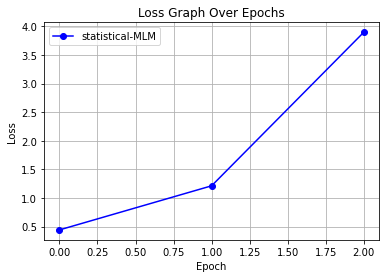

In [12]:
# Print loss graph
x = [i for i in range(0, len(loss_values_1))]
y = loss_values_1
# Create a line plot for loss
plt.plot(x, y, marker='o', linestyle='-', color='blue', label='statistical-MLM')
plt.legend()
# Adding labels and title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Graph Over Epochs')
# Display the plot
plt.grid(True)  # Add grid lines
plt.show()

### Model Testing

In [14]:
from transformers import pipeline, AutoModelForMaskedLM, AutoTokenizer, BertTokenizer
import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
model_path ='E:\\FYP\\Jupyter\\trained_model'
model=AutoModelForMaskedLM.from_pretrained(model_path)
tokenizer= BertTokenizer.from_pretrained('bert-base-uncased')
text = "They held entrance [MASK] for admission to the post- graduate course"
pipe = pipeline('fill-mask', model=model, tokenizer=tokenizer)
for x in pipe(text):
    print(x)

{'score': 0.7842796444892883, 'token': 0, 'token_str': '[PAD]', 'sequence': 'they held entrance for admission to the post - graduate course'}
{'score': 0.01900656521320343, 'token': 1996, 'token_str': 'the', 'sequence': 'they held entrance the for admission to the post - graduate course'}
{'score': 0.012249642983078957, 'token': 1012, 'token_str': '.', 'sequence': 'they held entrance. for admission to the post - graduate course'}
{'score': 0.01058429665863514, 'token': 1997, 'token_str': 'of', 'sequence': 'they held entrance of for admission to the post - graduate course'}
{'score': 0.007313388865441084, 'token': 1010, 'token_str': ',', 'sequence': 'they held entrance, for admission to the post - graduate course'}
